In [1]:
import time
import os
import sys

start_time = time.time()

## Building a GPT

Companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

In [3]:
# read it in to inspect it
with open('don_quijote.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  2129506


In [5]:
# let's look at the first 1000 characters
print(text[:1000])

Title: Don Quijote

Author: Miguel de Cervantes Saavedra

Release date: December 1, 1999 [eBook #2000]
                Most recently updated: January 17, 2021

Language: Spanish

Credits: an anonymous Project Gutenberg volunteer and Joaquin Cuenca Abela

*** START OF THE PROJECT GUTENBERG EBOOK DON QUIJOTE ***

El ingenioso hidalgo don Quijote de la Mancha

por Miguel de Cervantes Saavedra

El ingenioso hidalgo don Quijote de la Mancha

Tasa
  
Testimonio de las erratas
  
El Rey
  
Al Duque de Béjar
  
Prólogo
  
Al libro de don Quijote de la Mancha

Que trata de la condición y ejercicio del famoso
hidalgo don Quijote de la Mancha

Que trata de la primera salida que de su tierra hizo
el ingenioso don Quijote

Donde se cuenta la graciosa manera que tuvo don
Quijote en armarse caballero

De lo que le sucedió a nuestro caballero cuando salió
de la venta

Donde se prosigue la narración de la desgracia de
nuestro caballero

Del donoso y grande escrutinio que el cura y el
barbero hicieron e

In [6]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !"#$%'()*,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz¡«»¿ÁÉÍÑÓÚàáéíïñóùúü—‘’“”•™
109


In [7]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[63, 64, 64, 1, 75, 63, 60, 73, 60]
hii there


In [8]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([2129506]) torch.int64
tensor([47, 64, 75, 67, 60, 25,  1, 31, 70, 69,  1, 44, 76, 64, 65, 70, 75, 60,
         0,  0, 28, 76, 75, 63, 70, 73, 25,  1, 40, 64, 62, 76, 60, 67,  1, 59,
        60,  1, 30, 60, 73, 77, 56, 69, 75, 60, 74,  1, 46, 56, 56, 77, 60, 59,
        73, 56,  0,  0, 45, 60, 67, 60, 56, 74, 60,  1, 59, 56, 75, 60, 25,  1,
        31, 60, 58, 60, 68, 57, 60, 73,  1, 16, 11,  1, 16, 24, 24, 24,  1, 54,
        60, 29, 70, 70, 66,  1,  4, 17, 15, 15, 15, 55,  0,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 40, 70, 74, 75,  1, 73, 60,
        58, 60, 69, 75, 67, 80,  1, 76, 71, 59, 56, 75, 60, 59, 25,  1, 37, 56,
        69, 76, 56, 73, 80,  1, 16, 22, 11,  1, 17, 15, 17, 16,  0,  0, 39, 56,
        69, 62, 76, 56, 62, 60, 25,  1, 46, 71, 56, 69, 64, 74, 63,  0,  0, 30,
        73, 60, 59, 64, 75, 74, 25,  1, 56, 69,  1, 56, 69, 70, 69, 80, 68, 70,
        76, 74,  1, 43, 73, 70, 65, 60, 58, 75,  1, 34, 76, 75, 60, 69, 57, 60,
      

In [9]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [10]:
block_size = 8
train_data[:block_size+1]

tensor([47, 64, 75, 67, 60, 25,  1, 31, 70])

In [11]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([47]) the target: 64
when input is tensor([47, 64]) the target: 75
when input is tensor([47, 64, 75]) the target: 67
when input is tensor([47, 64, 75, 67]) the target: 60
when input is tensor([47, 64, 75, 67, 60]) the target: 25
when input is tensor([47, 64, 75, 67, 60, 25]) the target: 1
when input is tensor([47, 64, 75, 67, 60, 25,  1]) the target: 31
when input is tensor([47, 64, 75, 67, 60, 25,  1, 31]) the target: 70


In [12]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[76, 60, 67, 75, 70, 74,  1, 62],
        [69, 60, 74, 75, 60, 73, 70, 74],
        [70, 74,  1, 76, 68, 57, 73, 56],
        [64, 68, 60, 73, 70, 11,  1, 60]])
targets:
torch.Size([4, 8])
tensor([[60, 67, 75, 70, 74,  1, 62, 56],
        [60, 74, 75, 60, 73, 70, 74, 70],
        [74,  1, 76, 68, 57, 73, 56, 67],
        [68, 60, 73, 70, 11,  1, 60, 69]])
----
when input is [76] the target: 60
when input is [76, 60] the target: 67
when input is [76, 60, 67] the target: 75
when input is [76, 60, 67, 75] the target: 70
when input is [76, 60, 67, 75, 70] the target: 74
when input is [76, 60, 67, 75, 70, 74] the target: 1
when input is [76, 60, 67, 75, 70, 74, 1] the target: 62
when input is [76, 60, 67, 75, 70, 74, 1, 62] the target: 56
when input is [69] the target: 60
when input is [69, 60] the target: 74
when input is [69, 60, 74] the target: 75
when input is [69, 60, 74, 75] the target: 60
when input is [69, 60, 74, 75, 60] the target: 73
when input 

In [13]:
print(xb) # our input to the transformer

tensor([[76, 60, 67, 75, 70, 74,  1, 62],
        [69, 60, 74, 75, 60, 73, 70, 74],
        [70, 74,  1, 76, 68, 57, 73, 56],
        [64, 68, 60, 73, 70, 11,  1, 60]])


In [14]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


torch.Size([32, 109])
tensor(4.7322, grad_fn=<NllLossBackward0>)

1"éI#Q “"M«CPotEfSTY(5‘3.9TPükJG]v0w5B63)1™.7q‘'.VpzZe¡(’F;QfÓ4UFiO7$h6é#v)hó
#“Mà'BÍs'G4Á“
DX.’
qK«


In [15]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [16]:
batch_size = 32
for steps in range(100): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


4.9228434562683105


In [17]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


#eQü yG•-$»H. X0
esüFRAk“b[I8CFZ!•ÚL*Íú.B•ó¿SÓÓM¡yvù¡7¿laúUE•7cWq•«Ía•M’NÚ#yY•T[N.gfÁ!ùG1h‘ï1,™ÉoJ44VP'”g##O$Kf“-•,6Hnvï“oÉjÁ—;0ó’qÚvZRra»TúYÉQKPjI1q”DWv/H’O1’a aYán)”Gc:$:¡“"#M.dÁrÁÑ!tRt!ccr».oïvmR,;.Z;ÓbSH2q¿E»Bü””v37VH# V™7”I‘J5NKùRAesï“’WákYÉ
yGÍwTáeb’ü1fSUen.Y#ï’N55H•ïï3Iv7W:¡óB# 1YK/LQ‘óirNáO;aGch]«xO$ñZ3J8«d)éUnáX,[pTKB6¡ó»ml’aé$¡éÉmraÉ”!o-forÉa5•!L;”?WFiat6BÍo»hg[t*r-]ñíÓ4zACp;'à:i3™rÑ.$7Pm 6ÉG.Ó ùx[Á#«JPoGgd)w™:¡9(oÉpy•]«*.HÉ(%,ïLÍY“Z-RhI8uUE#";”6isKZ«Xuc7.hOK«[p.5$:Q-t)üUfjJyeHc ™Ló'
a


## The mathematical trick in self-attention

In [19]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [20]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [21]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)


In [22]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)

True

In [23]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)


True

In [24]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [25]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [27]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [28]:
k.var()

tensor(1.0449)

In [29]:
q.var()

tensor(1.0700)

In [30]:
wei.var()

tensor(1.0918)

In [31]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [32]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [33]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [34]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [35]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-3.5763e-09), tensor(1.0000))

In [36]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>



### Full finished code, for reference

You may want to refer directly to the git repo instead though.

In [38]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('don_quijote.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_train = []
loss_val = []
iter_eval = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()

        time_sec = round(time.time() - start_time, 2)
        time_min = time_sec / 60

        message = (
            f"....| step {iter} | train loss {losses['train']:.4f} | "
            f"val loss {losses['val']:.4f} | "
            f"{time_sec:.2f} seconds | {time_min:.2f} minutes |...."
        )
        sys.stdout.write("\r" + message)
        sys.stdout.flush()

        iter_eval.append(iter)
        loss_train.append(losses['train'])
        loss_val.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


0.215405 M parameters
....| step 4999 | train loss 1.5897 | val loss 1.8887 | 137.14 seconds | 2.29 minutes |....

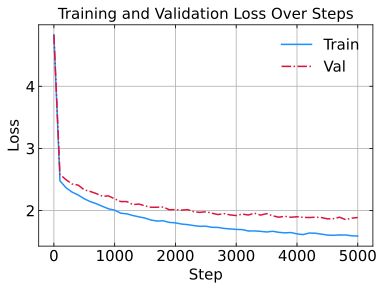

In [39]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format= 'svg'

font_size = 15

# Plot training loss
plt.figure(figsize=(6, 4))
plt.plot(iter_eval, loss_train,
         label='Train',
         color='dodgerblue',
         # marker='o', 
         linestyle='-')
plt.plot(iter_eval, loss_val,
         label='Val',
         color='crimson',
         # marker='o', 
         linestyle='-.')

plt.legend(
        fontsize=font_size,
        ncol=1,
        frameon=False,
        framealpha=1,
        # loc="upper right",
        # handletextpad=0.0,
        # markerscale=2,
    )

plt.tick_params(
        labelsize=font_size,
        direction="in",
        bottom=True,
        top=True,
        left=True,
        right=True,
    )

plt.xlabel("Step", fontsize=font_size)
plt.ylabel("Loss", fontsize=font_size)
plt.title("Training and Validation Loss Over Steps", fontsize=font_size)
plt.grid()
# plt.show()

In [40]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))



— Aquí que quieremo y había dice, hecho, hafreción, si lo flige—no la jorios, lo quedó se su pudero, toriéesme. Cabra por erró marid, que es el guento señor; la
muestra, porque

de eras uno
caballor esta un liego a Dios de la que vuesta miraja, cuantas,
aciados
antados de Mavita de Dios hator cuatra la duvierse, ¡a esta la pasegura y sinto algar sol muerto, pero opeldos y adosas, con él se vuestra escubriliendo ordención, tan opriberio en oc ántas de las isadanses una laced de su magrar paldro que de duelma que sobra decir una caluatro XXVieron en pasar ni mentes, y cuando de loferís la cuadas quieríase muertes traño
especatamde en la ajes, ni muestra mi bien el pueblo.


Parzar más yol de bos; y éstan estaban antó del Qastijote. Dijos, ni le hagago cuantas que no si no enagápoció en vuesable
escuberde, dijo en manda que pasiese tormo de donde a Diegos, más le
pastaba. Cacelas corce deciráis quisí con y con suforer de Sanza que docice Vinaladras brental fuese
donde sir a
mis oyeca qu